# Spectroscopy Concept

In this note, 
1. I will show you how the spectroscopic data look like,
2. use a data from a publication ([Greco+2018 ApJ](https://ui.adsabs.harvard.edu/abs/2018ApJ...866..112G/abstract)) to do some Bayesian analysis

**Please refer to our ``Books/`` directory.**

## 1. How the Realistic Data Look Like
The following image shows an example of spectroscopic data. In the middle, there is the spectrum of the target. As you expect, the horizontal axis is the wavelength direction (depending on the instrument, but I described the wavelength increases towards right). But since the slit has finite width, much larger than the point source we are observing, there are sky spectra towards up/down direction. This vertical direction is called the spatial direction.
![](figs/spec_concept.png)

## 2. Greco+18 data
In Greco+2018 paper, they derived the following spectra of the two diffuse dwarf galaxies: 
![](figs/Greco2018F1.png)
Figure 1 caption: HSC-SSP gri (Lupton et al. 2004) composite images of LSBG-285 (left column) and LSBG-750 (right column). In each HSC-SSP panel, the red lines show the slit position (Section 3.1).

![](figs/Greco2018F2.png)
Figure 2 caption: 2D (top) and 1D (bottom) spectra of LSBG-285 (left) and LSBG-750 (right). Red lines show individual 0.6 kpc extractions, and blue points show the full galaxy extraction. The red 1D spectra have been scaled by a factor of two for visibility. The best-fit spectral-line models (Section 3.2) are indicated by the black lines. The median [N II] λ6583/Hα value and associated 16th and 84th percentile uncertainties, which we derive from the marginalized posterior probability distributions, are indicated near each spectrum in the relevant panels.

### Explanation of the data
The authors studied the two diffuse dwarf galaxies, discovered from Subaru HSC-SSP. The follow-up observation was made by Gemini-South's GMOS (optical long-slit spectroscopy). From the long-slit, they can extract the fluxes of [O III] (or [O<sup>2+</sup>]), Hβ, and [NII] (or [N<sup>+</sup>]). From the ratio of [O<sup>2+</sup>]/Hβ and [N<sup>+</sup>]/Hα, we can plot the BPT diagram (Fig 4 of the paper). In this work, they calculated Hα flux by assuming Hα/Hβ = 2.81, which is the _Case B_ recombination equilibrium case for 10000 K at electron number density 10<sup>8</sup> m<sup>-3</sup>. This is possible because they couldn't find an evidence for dust extinction in the galaxy from the SED fitting (from Fig 3 of the paper, A < 0.1 for V-band). From Hα, they used an empirical relationship to get the star formation rate (SFR), although it maybe uncertain to use the relation down to these faint objects.

For the observation, they used 831 lines/mm grating with the wide slit width 2-arcsec. The data underwent 4-pixel binning, which results in 0.3 arcsec/pixel in spatial and 1.5 Å/pixel (~70 km/s at 6563Å) in dispersion direction, covering wavelengths of 4800 to 7200 Å. 

The obtained 2-D spectra (top panel of Figure 2) is chopped into 0.6 kpc in spatial direction (red dashes), and each strip's spectrum is extracted below (red histograms). The combined spectrum with error-bars are shown at the bottom. 

Here we want to examine the "Full extraction" data of LSBG-285 at [O<sup>2+</sup>] wavelength region.

I extracted the data manually from [WebPlotDitigizer](https://automeris.io/WebPlotDigitizer/):
![](figs/Greco2018webplotdititizer.png)

In [1]:
from IPython.display import Video
Video("figs/Greco2018webplotdititizer.mp4", width=700)

## 3. Model Selection

In [10]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

def gauss(x, amp, mu, sig):
    return amp * np.exp(-(x - mu)**2/(2*sig**2))

def const_g(x, amp, mu, sig, const):
    return const + gauss(x, amp, mu, sig)

In [4]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

In [5]:
DATADIR = Path("..")/"data"
data_raw = pd.read_csv(DATADIR/"Greco2018_data.csv", names=["wl", "fl"])
data = dict(wlen=[], flux=[], dflux=[])
for i in range(data_raw.shape[0]//2):
    row1 = data_raw.iloc[2*i]
    row2 = data_raw.iloc[2*i+1]
    wl1, wl2 = row1["wl"], row2["wl"]
    fl1, fl2 = row1["fl"], row2["fl"]
    if abs(wl1 - wl2) > 1:
        print(f"{2*i}- and {2*i+1}-th row have problems?")
    wlen = np.mean([row1["wl"], row2["wl"]])
    flux = min(fl1, fl2)
    dflux = max(fl1, fl2) - flux
    data["wlen"].append(wlen)
    data["flux"].append(flux*1.e-20)  # unit of J/s/m2/Å, not cgs.
    data["dflux"].append(dflux*1.e-20)
data = pd.DataFrame.from_dict(data)

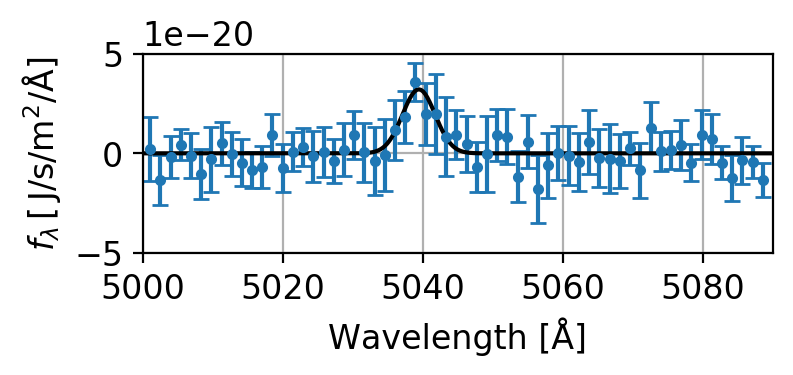

lg(flux) = -15.73 [mW/m2] 
 λ_c = 5039.4 [Å] 
 σ_v = 2.33 [Å]
[3.21328795e-20 5.03942509e+03 2.32657786e+00]


In [6]:
xx = np.linspace(5000, 5090, 300)
wlen = data["wlen"]
flux = data["flux"]
ferr = data["dflux"]
function = gauss
popt, _ = curve_fit(function, wlen, flux, sigma=ferr, 
                    absolute_sigma=True, p0=[1.e-20, 5039, 1])

fig, axs = plt.subplots(1, 1, figsize=(4.3, 2))

axs.errorbar(wlen, flux, ferr,
             marker='.', capsize=3, ls='')
axs.plot(xx, function(xx, *popt), 'k-')
axs.set(xlim=(5000, 5090), ylim=(-5e-20, 5e-20),
        xlabel="Wavelength [Å]",
        ylabel=r"$f_\lambda \,[\,\mathrm{J/s/m^2/\AA}]$")
axs.grid()
plt.tight_layout()
plt.show()

flux_fit = popt[0] * np.sqrt(2*np.pi*popt[2]**2)
lgf_mW = np.log10(flux_fit) + 3
print("lg(flux) = {:.2f} [mW/m2] \n λ_c = {:.1f} [Å] \n σ_v = {:.2f} [Å]"
      .format(lgf_mW, popt[1], popt[2]))
print(popt)

Looks similar to the original one, huh? :) 

* **NOTE**: The original paper obtained $\log_{10} F_{\mathrm{O III}} / \mathrm{erg\, cm^{-2}\, s^{-1}} = -15.7 \pm 0.1 $, where $ 1 \mathrm{erg\, cm^{-2}\, s^{-1}} = 1 \mathrm{mW/m^2} $.
* **NOTE**: The original paper argue that they used gaussian with flat spectrum. When I tried this, however, the best fit constant is -1.36e-21, which must be a marginally visible negative shift to the fitted Gaussian, but I cannot find this by zooming in the paper's plot. Thus, I guess they may have just ignored this flat offset or set a bound that this constant must be positive, so that the best fit value is just 0.
> From the paper: When fitting the [O III] λ5007 line, we assume a flat continuum plus a single Gaussian line profile with standard deviation given by the Hα fit.

In [7]:
C_sigma = np.sum(np.log(1/np.sqrt(2*np.pi*ferr**2)))
print(f"C_sigma = {C_sigma:.4f}")


def model_H0(x):
    return 0

def model_H1(x, amp, mu, sig):
    return gauss(x, amp, mu, sig)

def lgl(x, y, sigma, model, *model_args, **model_kwargs):    
#     const = np.sum(np.log(1/np.sqrt(2*np.pi*sigma**2)))
    const = C_sigma
    y_hat = model(x, *model_args, **model_kwargs)
    chisq = np.sum(((y - y_hat)/sigma)**2)
    return const - 0.5*chisq

N = len(flux)
n_0 = 0
n_1 = 3
lgl_0 = lgl(wlen, flux, ferr, model_H0)
lgl_1 = lgl(wlen, flux, ferr, model_H1, *popt)
bic_0 = n_0 * np.log(N) - 2 * lgl_0
bic_1 = n_1 * np.log(N) - 2 * lgl_1
aic_0 = 2 * n_0 - 2 * lgl_0
aic_1 = 2 * n_1 - 2 * lgl_1

print("Log-likelihoods: ", lgl_0, lgl_1)
print(f"Odds = {np.exp(lgl_1 - lgl_0)}")
print()
print(f"BIC = {bic_0}, {bic_1}")
print(f"dBIC = {bic_0 - bic_1}")
print()
print(f"AIC = {aic_0}, {aic_1}")
print(f"dAIC = {aic_0 - aic_1}")

C_sigma = 2739.2343
Log-likelihoods:  2720.810233133312 2730.135840690245
Odds = 11221.732253254451

BIC = -5441.620466266624, -5447.93905978797
dBIC = 6.318593521345974

AIC = -5441.620466266624, -5454.27168138049
dAIC = 12.651215113865874


This is one of the worst way of coding. But to give you a very explicit sense how the chi-square calculation should be done, I used nested for loop without using, e.g., ``numba``.

In [8]:
sig = popt[2]  # fixed

arr_amp = np.arange(0.1, 6, 0.1)*1.e-20
arr_flux = arr_amp * np.sqrt(2*np.pi*sig**2)
arr_mu = np.arange(5030, 5050, 0.1)

arr_chi2 = np.zeros((arr_amp.shape[0], arr_mu.shape[0]))
for i, amp in enumerate(arr_amp):
    for j, mu in enumerate(arr_mu):
        resid = flux - gauss(wlen, amp, mu, sig)
        chi2 = np.sum((resid/ferr)**2)
        arr_chi2[i, j] = chi2
        
chi2_min = np.sum(((flux - gauss(wlen, *popt)) / ferr)**2)

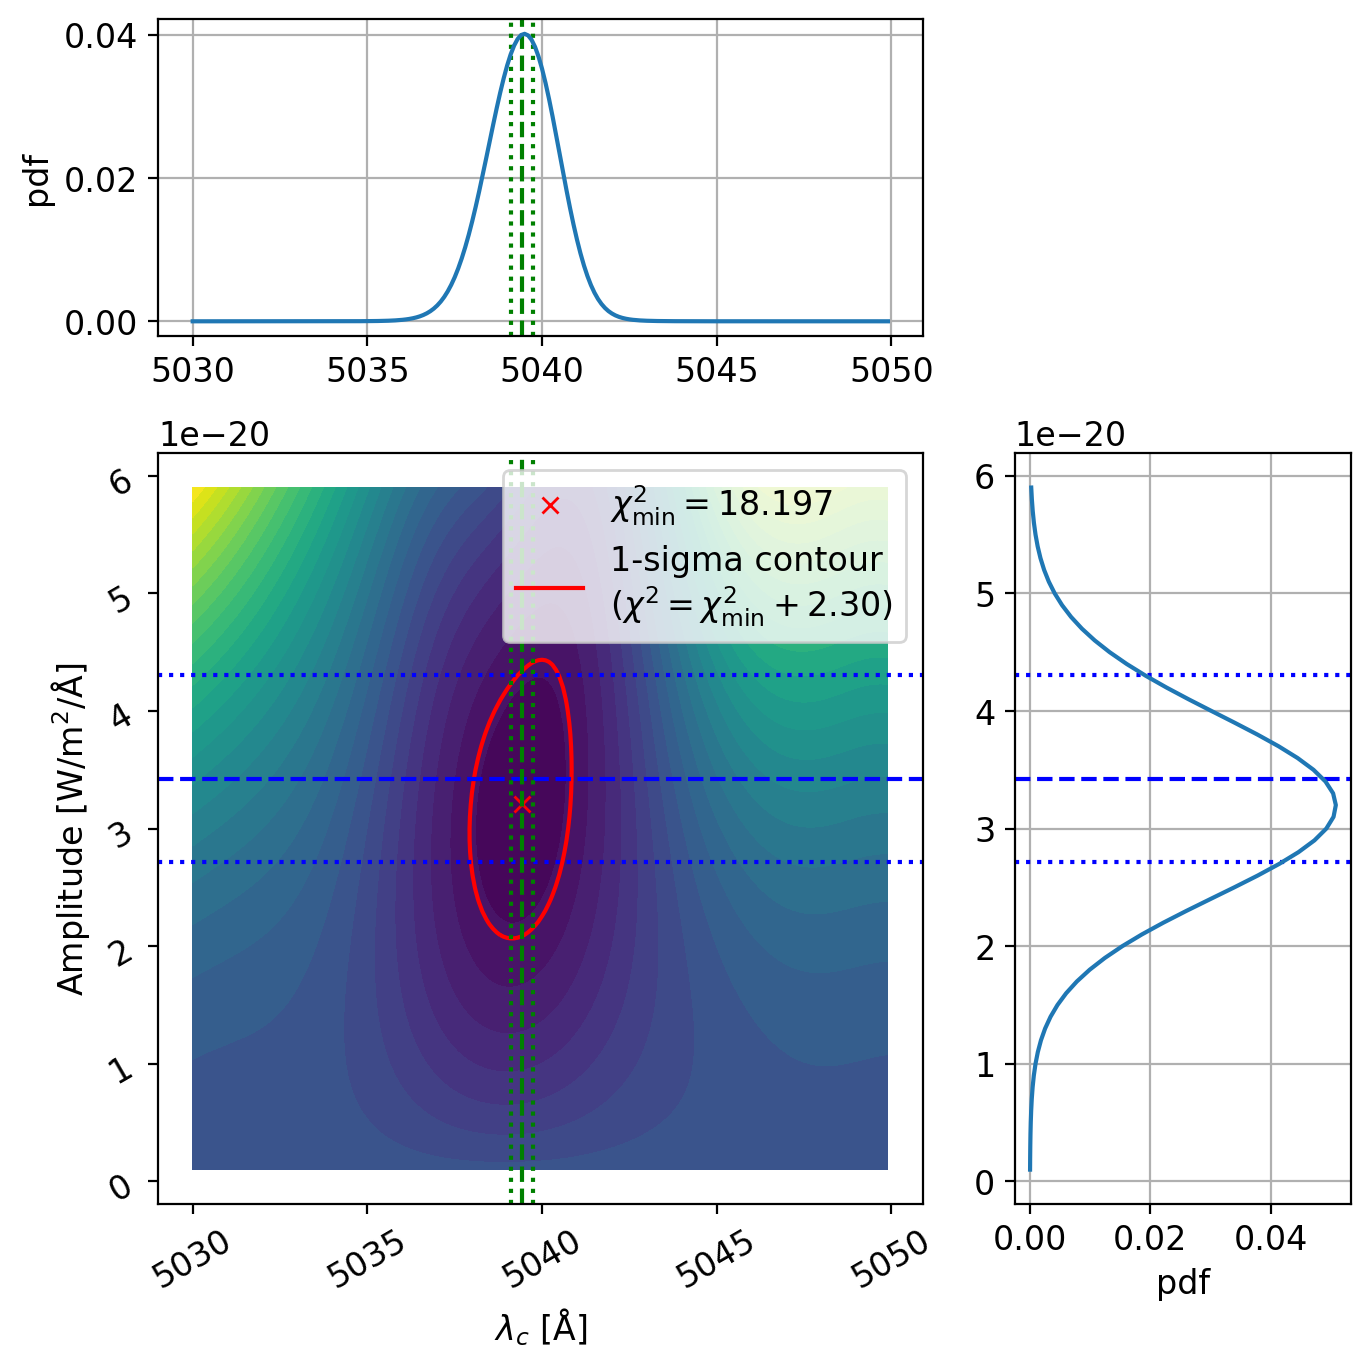

In [11]:
from matplotlib import gridspec
paper = dict(lgfl=-18.7, dlgfl=0.1)
paper["amp"] = 10**paper["lgfl"]/np.sqrt(2*np.pi*sig**2)
paper["amp_hi"] = 10**(paper["lgfl"] + paper["dlgfl"])/np.sqrt(2*np.pi*sig**2)
paper["amp_lo"] = 10**(paper["lgfl"] - paper["dlgfl"])/np.sqrt(2*np.pi*sig**2)
l_OIII = 5008.2  # Å in vacuo
dz = 6.3e-5

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(3, 3)
ax_c = fig.add_subplot(gs[1:, :2])      # chi2 contour
ax_l = fig.add_subplot(gs[0, :2], sharex=ax_c)  # central wavelength
ax_a = fig.add_subplot(gs[1:, 2], sharey=ax_c)  # amplitude

ax_c.contourf(arr_mu, arr_amp, arr_chi2, levels=30)
ax_c.plot(popt[1], popt[0], 'rx', 
          label=r"$\chi^2_\mathrm{{min}} = {:.3f}$".format(chi2_min))
cs = ax_c.contour(arr_mu, arr_amp, arr_chi2, 
                  levels=[chi2_min + 2.30], colors='r')
ax_c.plot(np.nan, np.nan, 'r-', 
          label="1-sigma contour\n" + r"($\chi^2 = \chi^2_\mathrm{min} + 2.30$)")
ax_c.tick_params(rotation=30)
ax_c.set(xlabel=r"$\lambda_c$ [Å]", ylabel=r"Amplitude [$\mathrm{W/m^2/\AA}$]")

for ax in [ax_c, ax_a]:
    ax.axhline(paper["amp"], color='b', ls='--')
    ax.axhline(paper["amp_hi"], color='b', ls=':')
    ax.axhline(paper["amp_lo"], color='b', ls=':')

for ax in [ax_c, ax_l]:
    ax.axvline(popt[1], color='g', ls='--')
    ax.axvline(popt[1] + l_OIII*dz, color='g', ls=':')
    ax.axvline(popt[1] - l_OIII*dz, color='g', ls=':')
    
prob = np.exp(-arr_chi2/2)
norm = np.sum(prob)
prob_mu = np.sum((prob/norm), axis=0)
prob_amp = np.sum((prob/norm), axis=1)

ax_l.plot(arr_mu, prob_mu)
ax_a.plot(prob_amp, arr_amp)
ax_l.set(ylabel="pdf")
ax_a.set(xlabel="pdf")

ax_l.grid()
ax_a.grid()
ax_c.legend()
plt.tight_layout()
plt.show()

The green vertical lines:
- dashed = our best fit central wavelength
- dotted = the uncertainty range from the paper's redshift uncertainty measured from Hα line (1742 +- 19 km/s)
- Because their uncertainty is from Hα, which has signal much better than O<sup>2+</sup>, the error-bar is much smaller than ours.

The blue horizontal lines:
- dashed = paper's flux (10^(-15.7) mW/m2) converted to amplitude
- dotted = paper's uncertainty around the paper's value.
- The difference between our fit and paper's value is only 0.03 dex (maybe the authors obtained the identical value but just dropped the significance numbers)
- Error bars seem slightly understimated, but in reality if we use error bar of 0.14 dex in log scale, it's similar to ours. Maybe the authors just did not care about such detailed numbers, which is understandable.